Study the properties of each adjacency matrix


In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
import itertools
from scipy.spatial.distance import pdist, squareform
import networkx as nx
from community import community_louvain
from graphProcessingFunctions import *

Load Adjacency Matrices

In [2]:
recipe_ingredients_coocurrence_allingr = np.load('../data/Adjacency_Matrix_1.npy')
recipe_ingredients_coocurrence_firstword = np.load('../data/Adjacency_Matrix_2.npy')
recipes_sparsified = np.load('../data/Adjacency_Matrix_3.npy')
nutrition_info = np.load('../data/Adjacency_Matrix_4.npy')
nutrition_info_normalized = np.load('../data/Adjacency_Matrix_5.npy')
nutrition_info_normalized_sparsified = np.load('../data/Adjacency_Matrix_6.npy')
combined_recipe_nutrition = np.load('../data/Adjacency_Matrix_8.npy')
combined_recipe_nutrition_norm = np.load('../data/Adjacency_Matrix_7.npy')
combined_recipe_nutrition_addition = np.load('../data/Adjacency_Matrix_9.npy')
combined_recipe_nutrition_addition_mean = np.load('../data/Adjacency_Matrix_10.npy')
combined_recipe_nutrition_mult = np.load('../data/Adjacency_Matrix_11.npy')

In [3]:
ingredient_list_full = np.load(('../data/Ingredient_List.npy'))
ingredient_list_firstword = np.load(('../data/Ingredient_List_First_Word.npy'))
ingredient_list_usda = np.load(('../data/Ingredient_List_USDA_Nutrition_Info.npy'))

In [13]:
def studyMatrixProperties(adj_mat, ingredient_list):
    feature_graph = nx.from_numpy_matrix(adj_mat)
    nn = feature_graph.number_of_nodes()
    ne = feature_graph.number_of_edges()
    print('Number of nodes: {}, Number of edges: {}'.format(nn, ne))

    laplacian = compute_laplacian(adj_mat,True)
    lamb_norm, U_norm = spectral_decomposition(laplacian)
    conn_comp = compute_number_connected_components(lamb_norm,threshold=1e-12)
    print('Number of connected compopents: {0}'.format(conn_comp))
    if conn_comp == 1:
        diam = nx.diameter(feature_graph)
        print('Network diameter: {0}'.format(diam))
    sparsity = np.isnan(adj_mat).sum()/(adj_mat.shape[0]*2)
    print('Sparsity: {0}%'.format(sparsity*100))

    cc = nx.average_clustering(feature_graph)
    print('Clustering coefficient: {0}'.format(cc))

    #Use degree centrality to find hub ingredients
    centr = nx.degree_centrality(feature_graph)
    centrality_array = np.array(list(centr.items()))[:,1]
    centr_mean = np.mean(centrality_array)
    centr_std = np.std(centrality_array)
    indices = np.where(centrality_array > centr_mean + 2*centr_std )
    hubs = ingredient_list[indices]
    if len(hubs) > 0:
        print("Hub ingredients: {}".format(hubs))
    else:
        print("No hub ingredients")

    part = community_louvain.best_partition(feature_graph)
    mod = community_louvain.modularity(part,feature_graph) 
    print('Modularity: {0}'.format(mod))

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(lamb_norm)
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
    plt.title('Eigenvalues $L_{norm}$')
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,2)
    plt.title('Ingredient graph')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    degrees = [degree for node, degree in feature_graph.degree()]
    plt.hist(degrees);
    plt.show()
  

# Adjacency Matrix 1
Weights between ingredient nodes are equal to the number of recipes in which the two ingredients appear together in the Recipes 1M+ dataset.
We determine the "hub" ingredients by finding nodes with a centrality (percent of other nodes to which they are connected) more than twice the mean centrality.
We can see that the node degree distribution follows a random network model.

Number of nodes: 357, Number of edges: 26061
Number of connected compopents: 1
Network diameter: 3
Sparsity: 0.0%
Clustering coefficient: 0.7581120793331181
Hub ingredients: ['butter, without salt' 'honey' 'lemon juice, raw'
 'milk, fluid, 1% fat, without added vitamin a and vitamin d'
 'oil, olive, salad or cooking' 'salt, table' 'spices, garlic powder'
 'spices, pepper, black' 'sugars, brown' 'sugars, granulated'
 'water, bottled, generic' 'wheat flour, white, all-purpose, unenriched']
Modularity: 0.1958273973664841


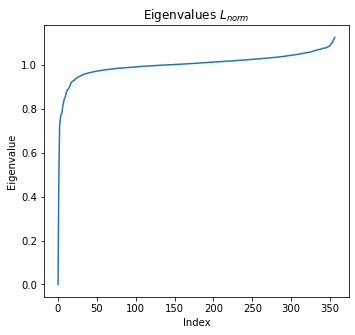

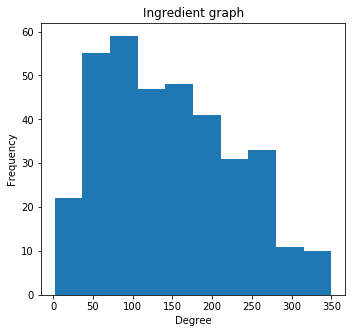

In [14]:
studyMatrixProperties(recipe_ingredients_coocurrence_allingr,ingredient_list_full)

# Adjacency Matrix 2
Weights between ingredient nodes are determined the same way as adjacency matrix #1 but using only the first word of each ingredient, which leads to slightly different "hub" ingredients, as multiple ingredients are merged into one. This network also follows a random graph node degree distribution.

Number of nodes: 213, Number of edges: 10810
Number of connected compopents: 1
Network diameter: 3
Sparsity: 0.0%
Clustering coefficient: 0.7860501427063846
Hub ingredients: ['oil' 'salt' 'spices' 'sugars' 'water']
Modularity: 0.14177474545402974


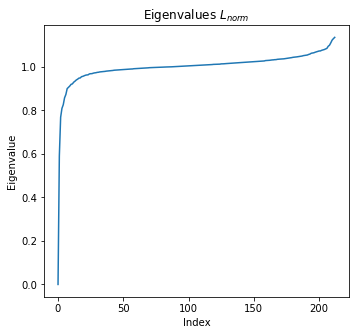

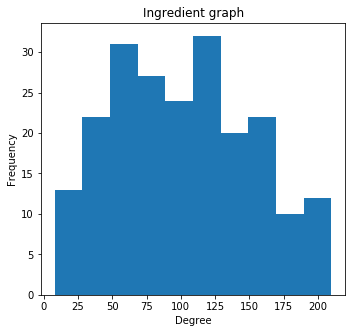

In [15]:
studyMatrixProperties(recipe_ingredients_coocurrence_firstword, ingredient_list_firstword)

### Adjacency Matrix No. 3
The adjacency matrix is built Cora-style (like we did in the first assignment): Have each recipe represent a "feature" for each ingredient. The feature equals 1 if the recipe includes that ingredient and 0 otherwise. Then use an RBF kernel to compute the distances between ingredients based on their feature vectors.

Since this matrix is sparser than the previous two, rare ingredients are disconnected from the rest and therefore the network has more connected components.

The network follows a sort of reverse power law node degree distribution where there are few low-degree nodes and many high-degree ones. This is also shown by the high clustering coefficient of the network, meaning that the nodes that are connected are highly clusered together.

Number of nodes: 357, Number of edges: 52031
Number of connected compopents: 28
Sparsity: 0.0%
Clustering coefficient: 0.8979877352056108
No hub ingredients
Modularity: 0.002098045154367012


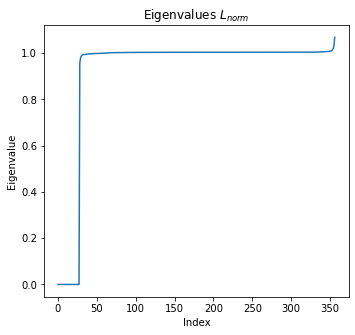

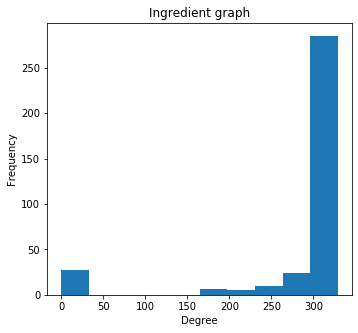

In [16]:
studyMatrixProperties(recipes_sparsified,ingredient_list_full)

### Adjacency Matrix No. 4
Weights are defined using an RBF kernel on nutrition information found from the USDA dataset. We can see that the network is also highly connected, with many degrees at high distributions.

Number of nodes: 313, Number of edges: 30681
Number of connected compopents: 6
Sparsity: 0.0%
Clustering coefficient: 0.9098472734651414
No hub ingredients
Modularity: 0.09906067591603898


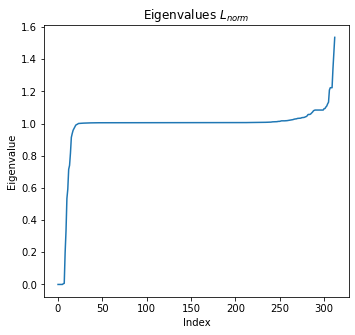

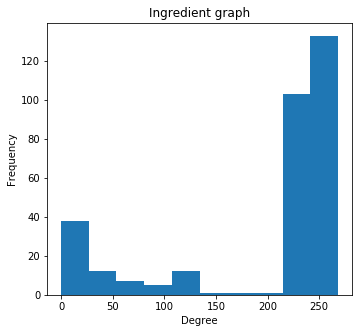

In [17]:
studyMatrixProperties(nutrition_info,ingredient_list_usda)

### Adjacency Matrix No. 5
Weights are defined using an RBF kernel on nutrition information found from the USDA dataset, which is divided by the mean nutrient value to maintain a constant comparison between nutrients. We can see that the network is also highly connected, with many degrees at high distributions, even moreso than Matrix #4

Number of nodes: 313, Number of edges: 36738
Number of connected compopents: 6
Sparsity: 0.0%
Clustering coefficient: 0.9376731215895305
No hub ingredients
Modularity: 0.07680121614396086


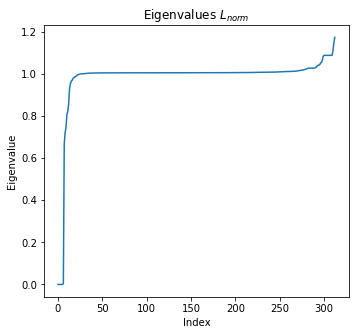

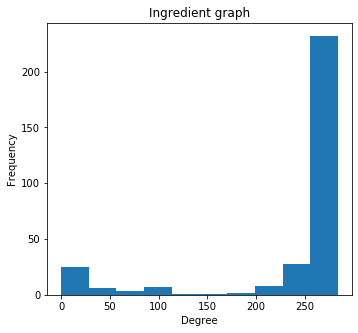

In [18]:
studyMatrixProperties(nutrition_info_normalized, ingredient_list_usda)

### Adjacency Matrix No. 6
This is the same matrix as #5 but sparsified more with a smaller kernel, so the clusering coefficient is lower and there are more connected components (i.e. disconnected ingredients). The degree distribution is also a sort of reversed power law.

Number of nodes: 313, Number of edges: 20233
Number of connected compopents: 11
Sparsity: 0.0%
Clustering coefficient: 0.850202892554816
No hub ingredients
Modularity: 0.1591540757952442


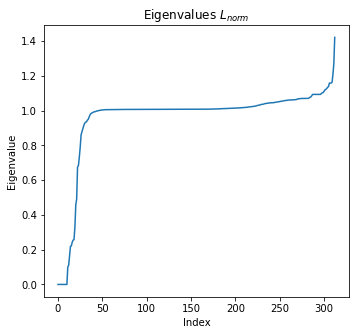

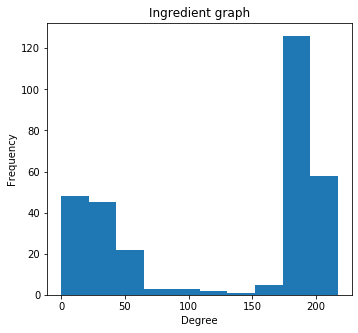

In [19]:
studyMatrixProperties(nutrition_info_normalized_sparsified, ingredient_list_usda)

## Adjacency Matrix No. 7
This matrix was developed by concatenating the nutrition features to the recipe features of matrix #4. Since there are many more recipe features than nutrition features, the graph properties are very similar to that of matrix #4.

Number of nodes: 313, Number of edges: 30713
Number of connected compopents: 6
Sparsity: 0.0%
Clustering coefficient: 0.9100225273187402
No hub ingredients
Modularity: 0.09892680316814169


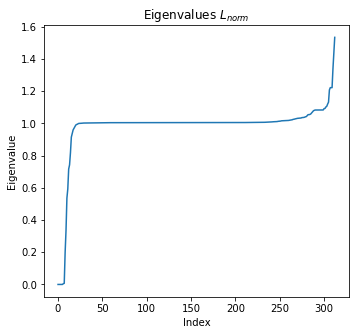

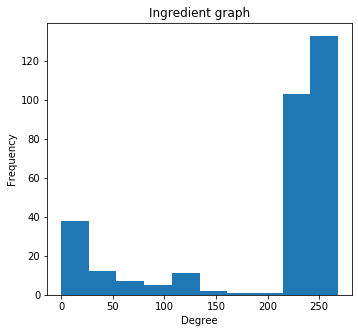

In [20]:
studyMatrixProperties(combined_recipe_nutrition, ingredient_list_usda)

## Adjacency Matrix No.8
In this matrix, the feature values from matrix #7 are divided by their mean before applying the RBF kernel in order to weigh the nutrition and feature data somewhat equally. This matrix is less connected than the previous one and therefore has more connected components. The degree distribution is a reversed power law.

Number of nodes: 313, Number of edges: 34662
Number of connected compopents: 40
Sparsity: 0.0%
Clustering coefficient: 0.8487214905694603
No hub ingredients
Modularity: 0.0033999989083642046


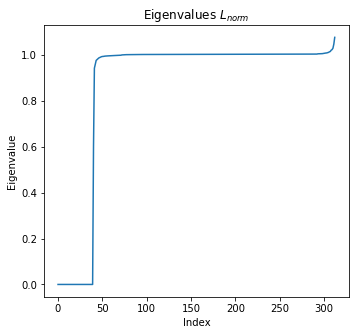

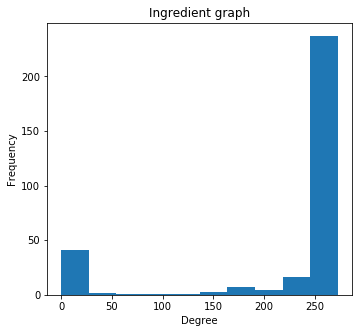

In [21]:
studyMatrixProperties(combined_recipe_nutrition_norm, ingredient_list_usda)

## Adjacency Matrix No. 9
This matrix was developped by adding matrices #1 (divided by its max value) and #5 to combine the recipe coocurrence and nutrition weights. The graph is fully connected and highly clustered with a reversed power law degree distribution.

Number of nodes: 313, Number of edges: 42759
Number of connected compopents: 1
Network diameter: 2
Sparsity: 0.0%
Clustering coefficient: 0.9362175102414722
No hub ingredients
Modularity: 0.07693707722542302


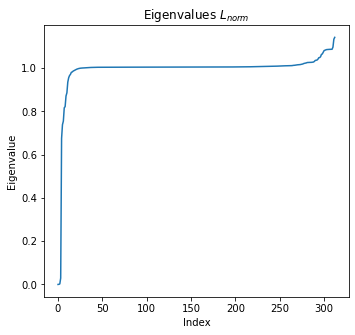

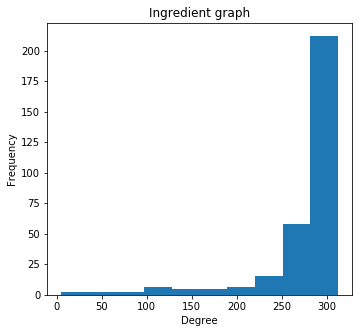

In [22]:
studyMatrixProperties(combined_recipe_nutrition_addition, ingredient_list_usda)

## Adjacency Matrix No. 10
This matrix was developped by adding matrices #1 (divided by its mean value) and #5 to combine the recipe coocurrence and nutrition weights. The graph is fully connected and highly clustered with a reversed power law degree distribution. It has a higher modularity than the previous matrix.

Number of nodes: 313, Number of edges: 42759
Number of connected compopents: 1
Network diameter: 2
Sparsity: 0.0%
Clustering coefficient: 0.9362175102414722
No hub ingredients
Modularity: 0.24003388209209864


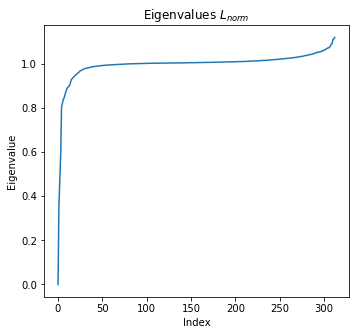

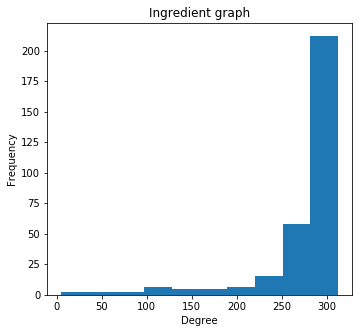

In [24]:
studyMatrixProperties(combined_recipe_nutrition_addition_mean, ingredient_list_usda)

## Adjacency Matrix No. 11
This matrix was developped by multiplying matrices #1 (divided by its max value) and #5 to combine the recipe coocurrence and nutrition weights. This is the only matrix with only very high eigenvalues, meaning lots of high-frequency activity on the graph. The degree distribution follows a random network model.

Number of nodes: 313, Number of edges: 15733
Number of connected compopents: 6
Sparsity: 0.0%
Clustering coefficient: 0.6956780533794216
Hub ingredients: ['butter, without salt' 'lemon juice, raw'
 'milk, fluid, 1% fat, without added vitamin a and vitamin d'
 'spices, garlic powder' 'spices, pepper, black' 'water, bottled, generic'
 'wheat flour, white, all-purpose, unenriched']
Modularity: 0.2864704550332474


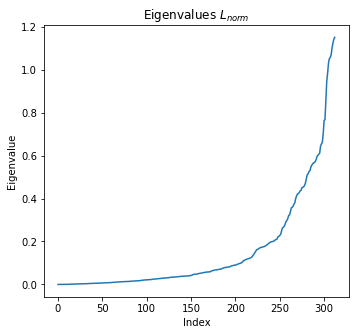

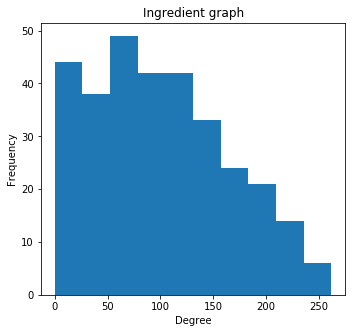

In [25]:
studyMatrixProperties(combined_recipe_nutrition_mult, ingredient_list_usda)